## 📦 Importar Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


## 🎲 Criar Dataset de E-commerce

In [2]:
np.random.seed(42)
n = 2000

# Gerar datas aleatórias em 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
date_range = (end_date - start_date).days

dates = [start_date + timedelta(days=np.random.randint(0, date_range)) for _ in range(n)]

# Dataset de compras
df = pd.DataFrame({
    'data_compra': dates,
    'valor_compra': np.random.lognormal(4, 0.8, n).clip(10, 1000),
    'desconto_pct': np.random.choice([0, 5, 10, 15, 20, 25], n, p=[0.3, 0.2, 0.2, 0.15, 0.1, 0.05]),
    'categoria': np.random.choice(['Eletrônicos', 'Roupas', 'Livros', 'Casa', 'Esportes'], n),
    'metodo_pagamento': np.random.choice(['Cartão', 'Boleto', 'Pix'], n, p=[0.5, 0.2, 0.3]),
    'num_itens': np.random.randint(1, 10, n),
    'tempo_site_min': np.random.exponential(15, n).clip(1, 120),
})

# Criar customer_id
df['customer_id'] = np.random.randint(1, 500, n)

# Target: se cliente voltou a comprar em 30 dias
df['voltou_30d'] = (np.random.random(n) < 0.35).astype(int)

# Aumentar probabilidade baseado em regras
df.loc[(df['valor_compra'] > 100) & (df['desconto_pct'] > 10), 'voltou_30d'] = \
    (np.random.random(sum((df['valor_compra'] > 100) & (df['desconto_pct'] > 10))) < 0.6).astype(int)

print(f"✅ Dataset criado: {df.shape}")
print(f"\n📊 Target:")
print(df['voltou_30d'].value_counts())
print(f"\n📈 Amostra:")
df.head(10)

✅ Dataset criado: (2000, 9)

📊 Target:
voltou_30d
0    1283
1     717
Name: count, dtype: int64

📈 Amostra:


,data_compra,valor_compra,desconto_pct,categoria,metodo_pagamento,num_itens,tempo_site_min,customer_id,voltou_30d
0,2024-04-12,124.490171,15,Roupas,Pix,5,1.000000,220,0
1,2024-12-14,66.090917,5,Eletrônicos,Pix,8,7.094173,230,0
2,2024-09-27,44.378996,10,Esportes,Pix,4,33.921483,434,0
3,2024-04-16,46.661533,5,Esportes,Boleto,4,4.816243,440,0
4,2024-03-12,51.558598,10,Eletrônicos,Cartão,8,4.784113,479,1
5,2024-07-07,52.996306,5,Roupas,Cartão,5,5.406421,372,0
6,2024-01-21,97.719745,0,Esportes,Cartão,6,14.213369,265,0
7,2024-04-12,56.914874,0,Livros,Boleto,5,8.652686,264,1
8,2024-05-01,98.112233,0,Eletrônicos,Boleto,1,19.459690,110,0
9,2024-08-02,51.183987,25,Casa,Pix,7,33.794164,403,1


## 📅 1. Features de Tempo

Extrair componentes úteis de datas.

In [3]:
# Converter para datetime
df['data_compra'] = pd.to_datetime(df['data_compra'])

# Extrair componentes básicos
df['ano'] = df['data_compra'].dt.year
df['mes'] = df['data_compra'].dt.month
df['dia'] = df['data_compra'].dt.day
df['dia_semana'] = df['data_compra'].dt.dayofweek  # 0=Segunda, 6=Domingo
df['semana_ano'] = df['data_compra'].dt.isocalendar().week
df['trimestre'] = df['data_compra'].dt.quarter
df['dia_ano'] = df['data_compra'].dt.dayofyear

# Features derivadas
df['fim_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['inicio_mes'] = (df['dia'] <= 10).astype(int)
df['fim_mes'] = (df['dia'] >= 20).astype(int)
df['black_friday'] = ((df['mes'] == 11) & (df['dia'].between(20, 30))).astype(int)
df['natal'] = ((df['mes'] == 12) & (df['dia'] >= 15)).astype(int)

# Nome do dia da semana
dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
df['nome_dia'] = df['dia_semana'].map(lambda x: dias_semana[x])

print("✅ Features de tempo criadas!\n")
print("📊 Novas features:")
time_features = ['ano', 'mes', 'dia', 'dia_semana', 'trimestre', 'fim_semana', 
                 'inicio_mes', 'fim_mes', 'black_friday', 'natal']
print(time_features)

print("\n📈 Amostra:")
df[['data_compra', 'nome_dia', 'fim_semana', 'black_friday', 'natal']].head(10)

✅ Features de tempo criadas!

📊 Novas features:
['ano', 'mes', 'dia', 'dia_semana', 'trimestre', 'fim_semana', 'inicio_mes', 'fim_mes', 'black_friday', 'natal']

📈 Amostra:


,data_compra,nome_dia,fim_semana,black_friday,natal
0,2024-04-12,Sexta,0,0,0
1,2024-12-14,Sábado,1,0,0
2,2024-09-27,Sexta,0,0,0
3,2024-04-16,Terça,0,0,0
4,2024-03-12,Terça,0,0,0
5,2024-07-07,Domingo,1,0,0
6,2024-01-21,Domingo,1,0,0
7,2024-04-12,Sexta,0,0,0
8,2024-05-01,Quarta,0,0,0
9,2024-08-02,Sexta,0,0,0


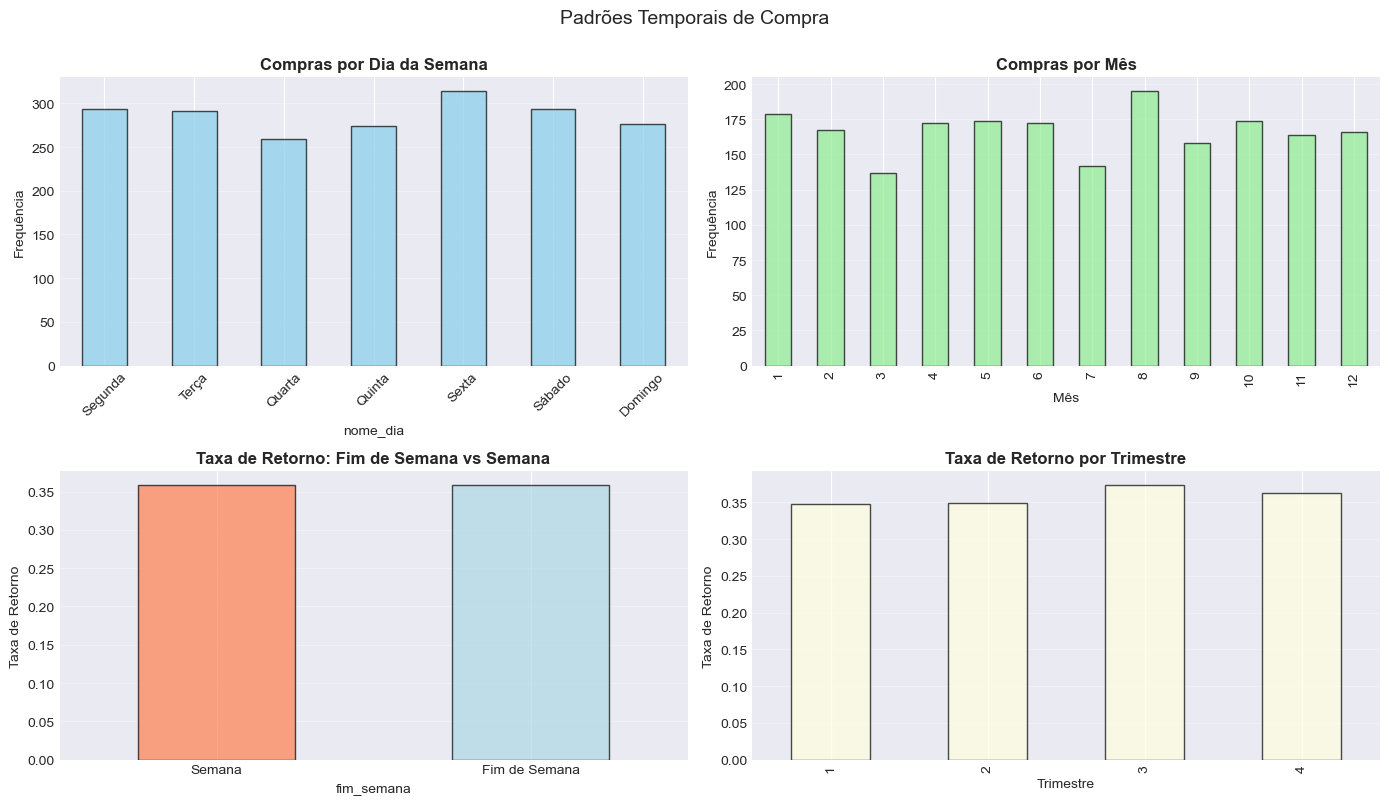


📊 Insights:
Taxa retorno fim de semana: 0.359
Taxa retorno semana:        0.358


In [4]:
# Visualizar padrões temporais
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Padrões Temporais de Compra', fontsize=14, y=1.00)

# Compras por dia da semana
df['nome_dia'].value_counts().reindex(dias_semana).plot(kind='bar', ax=axes[0, 0], 
                                                          color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Compras por Dia da Semana', fontweight='bold')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Compras por mês
df['mes'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1],
                                            color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Compras por Mês', fontweight='bold')
axes[0, 1].set_xlabel('Mês')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Fim de semana vs semana
df.groupby('fim_semana')['voltou_30d'].mean().plot(kind='bar', ax=axes[1, 0],
                                                     color=['coral', 'lightblue'], 
                                                     alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Taxa de Retorno: Fim de Semana vs Semana', fontweight='bold')
axes[1, 0].set_xticklabels(['Semana', 'Fim de Semana'], rotation=0)
axes[1, 0].set_ylabel('Taxa de Retorno')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Trimestre
df.groupby('trimestre')['voltou_30d'].mean().plot(kind='bar', ax=axes[1, 1],
                                                    color='lightyellow', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Taxa de Retorno por Trimestre', fontweight='bold')
axes[1, 1].set_xlabel('Trimestre')
axes[1, 1].set_ylabel('Taxa de Retorno')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Insights:")
print(f"Taxa retorno fim de semana: {df[df['fim_semana']==1]['voltou_30d'].mean():.3f}")
print(f"Taxa retorno semana:        {df[df['fim_semana']==0]['voltou_30d'].mean():.3f}")

## 🔢 2. Combinações Matemáticas

Criar features derivadas de operações matemáticas.

In [5]:
# Features matemáticas
df['valor_desconto'] = df['valor_compra'] * (df['desconto_pct'] / 100)
df['valor_final'] = df['valor_compra'] - df['valor_desconto']
df['valor_por_item'] = df['valor_final'] / df['num_itens']
df['desconto_bool'] = (df['desconto_pct'] > 0).astype(int)
df['alto_valor'] = (df['valor_compra'] > df['valor_compra'].median()).astype(int)
df['muitos_itens'] = (df['num_itens'] >= 5).astype(int)
df['tempo_site_alto'] = (df['tempo_site_min'] > df['tempo_site_min'].median()).astype(int)

# Razões e proporções
df['razao_valor_tempo'] = df['valor_final'] / (df['tempo_site_min'] + 1)  # +1 para evitar divisão por 0
df['razao_desconto_valor'] = df['valor_desconto'] / (df['valor_compra'] + 1)

# Transformações log (para valores muito assimétricos)
df['log_valor'] = np.log1p(df['valor_compra'])
df['log_tempo_site'] = np.log1p(df['tempo_site_min'])

print("✅ Features matemáticas criadas!\n")
print("📊 Novas features:")
math_features = ['valor_desconto', 'valor_final', 'valor_por_item', 'desconto_bool',
                 'alto_valor', 'muitos_itens', 'razao_valor_tempo', 'log_valor']
print(math_features)

print("\n📈 Amostra:")
df[['valor_compra', 'valor_desconto', 'valor_final', 'valor_por_item', 'alto_valor']].head(10)

✅ Features matemáticas criadas!

📊 Novas features:
['valor_desconto', 'valor_final', 'valor_por_item', 'desconto_bool', 'alto_valor', 'muitos_itens', 'razao_valor_tempo', 'log_valor']

📈 Amostra:


,valor_compra,valor_desconto,valor_final,valor_por_item,alto_valor
0,124.490171,18.673526,105.816645,21.163329,1
1,66.090917,3.304546,62.786371,7.848296,1
2,44.378996,4.437900,39.941096,9.985274,0
3,46.661533,2.333077,44.328456,11.082114,0
4,51.558598,5.155860,46.402738,5.800342,0
5,52.996306,2.649815,50.346491,10.069298,0
6,97.719745,0.000000,97.719745,16.286624,1
7,56.914874,0.000000,56.914874,11.382975,1
8,98.112233,0.000000,98.112233,98.112233,1
9,51.183987,12.795997,38.387991,5.483999,0


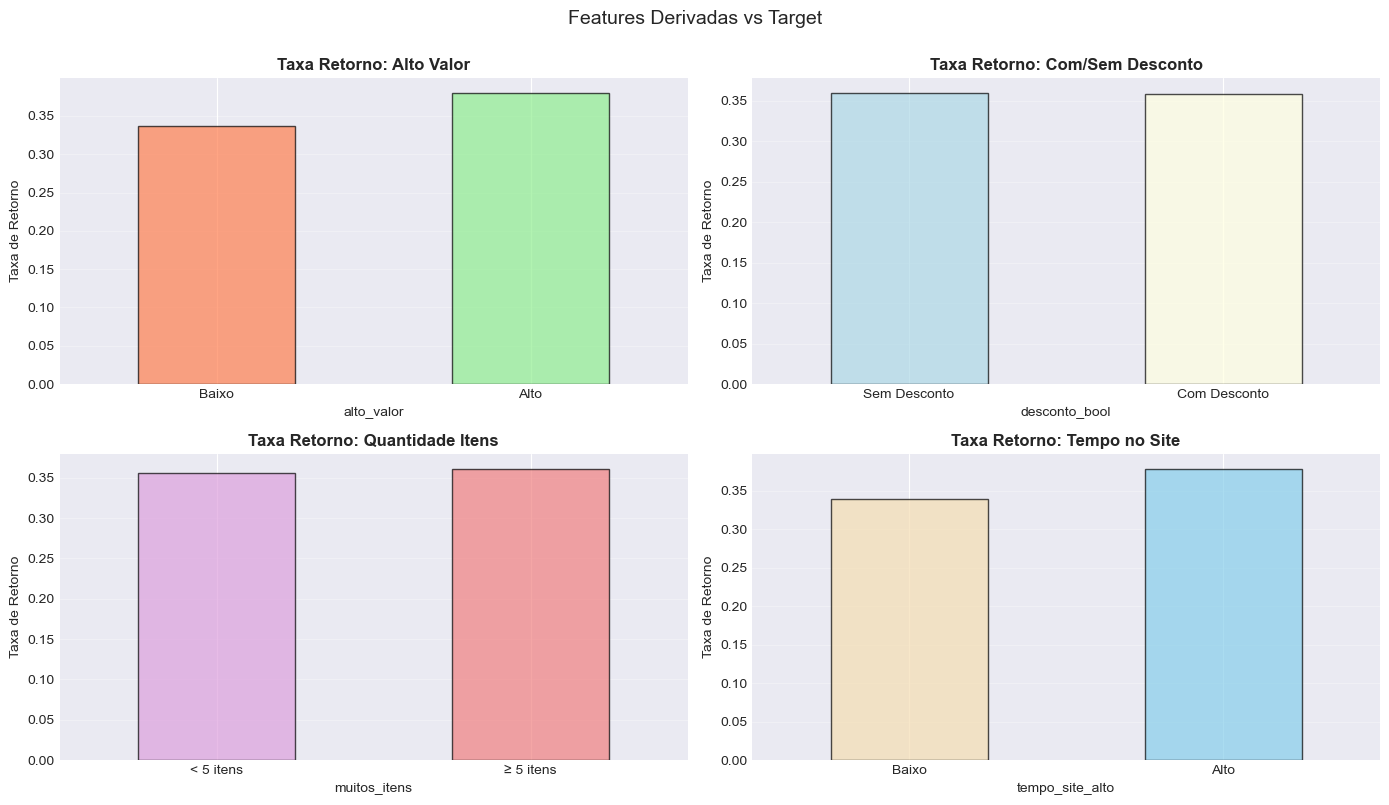


📊 Insights:
Alto valor:     0.380 vs 0.337
Com desconto:   0.358 vs 0.360
Muitos itens:   0.361 vs 0.356


In [6]:
# Visualizar novas features
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Features Derivadas vs Target', fontsize=14, y=1.00)

# Alto valor
df.groupby('alto_valor')['voltou_30d'].mean().plot(kind='bar', ax=axes[0, 0],
                                                     color=['coral', 'lightgreen'],
                                                     alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Taxa Retorno: Alto Valor', fontweight='bold')
axes[0, 0].set_xticklabels(['Baixo', 'Alto'], rotation=0)
axes[0, 0].set_ylabel('Taxa de Retorno')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Desconto
df.groupby('desconto_bool')['voltou_30d'].mean().plot(kind='bar', ax=axes[0, 1],
                                                        color=['lightblue', 'lightyellow'],
                                                        alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Taxa Retorno: Com/Sem Desconto', fontweight='bold')
axes[0, 1].set_xticklabels(['Sem Desconto', 'Com Desconto'], rotation=0)
axes[0, 1].set_ylabel('Taxa de Retorno')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Muitos itens
df.groupby('muitos_itens')['voltou_30d'].mean().plot(kind='bar', ax=axes[1, 0],
                                                       color=['plum', 'lightcoral'],
                                                       alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Taxa Retorno: Quantidade Itens', fontweight='bold')
axes[1, 0].set_xticklabels(['< 5 itens', '≥ 5 itens'], rotation=0)
axes[1, 0].set_ylabel('Taxa de Retorno')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Tempo site alto
df.groupby('tempo_site_alto')['voltou_30d'].mean().plot(kind='bar', ax=axes[1, 1],
                                                          color=['wheat', 'skyblue'],
                                                          alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Taxa Retorno: Tempo no Site', fontweight='bold')
axes[1, 1].set_xticklabels(['Baixo', 'Alto'], rotation=0)
axes[1, 1].set_ylabel('Taxa de Retorno')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Insights:")
print(f"Alto valor:     {df[df['alto_valor']==1]['voltou_30d'].mean():.3f} vs {df[df['alto_valor']==0]['voltou_30d'].mean():.3f}")
print(f"Com desconto:   {df[df['desconto_bool']==1]['voltou_30d'].mean():.3f} vs {df[df['desconto_bool']==0]['voltou_30d'].mean():.3f}")
print(f"Muitos itens:   {df[df['muitos_itens']==1]['voltou_30d'].mean():.3f} vs {df[df['muitos_itens']==0]['voltou_30d'].mean():.3f}")

## 📊 3. Features de Agregação

Criar features baseadas em estatísticas por cliente.

In [7]:
# Agregações por cliente
customer_agg = df.groupby('customer_id').agg({
    'valor_compra': ['mean', 'sum', 'std', 'count'],
    'desconto_pct': 'mean',
    'num_itens': 'sum',
    'tempo_site_min': 'mean'
}).reset_index()

# Renomear colunas
customer_agg.columns = ['customer_id', 'ticket_medio', 'valor_total', 
                        'std_valor', 'num_compras', 'desconto_medio',
                        'total_itens', 'tempo_medio_site']

# Features derivadas do cliente
customer_agg['cliente_frequente'] = (customer_agg['num_compras'] >= 3).astype(int)
customer_agg['alto_gasto'] = (customer_agg['valor_total'] > customer_agg['valor_total'].median()).astype(int)
customer_agg['variacao_compras'] = customer_agg['std_valor'] / (customer_agg['ticket_medio'] + 1)

# Merge com dataset original
df = df.merge(customer_agg, on='customer_id', how='left')

print("✅ Features de agregação criadas!\n")
print("📊 Features por cliente:")
agg_features = ['ticket_medio', 'valor_total', 'num_compras', 'desconto_medio',
                'cliente_frequente', 'alto_gasto']
print(agg_features)

print("\n📈 Estatísticas:")
print(customer_agg[['ticket_medio', 'valor_total', 'num_compras']].describe().round(2))

✅ Features de agregação criadas!

📊 Features por cliente:
['ticket_medio', 'valor_total', 'num_compras', 'desconto_medio', 'cliente_frequente', 'alto_gasto']

📈 Estatísticas:
       ticket_medio  valor_total  num_compras
count        491.00       491.00       491.00
mean          77.64       311.51         4.07
std           45.10       199.46         1.92
min           10.00        10.00         1.00
25%           50.86       171.78         3.00
50%           68.16       289.24         4.00
75%           93.13       409.46         5.00
max          496.57      1429.17        10.00


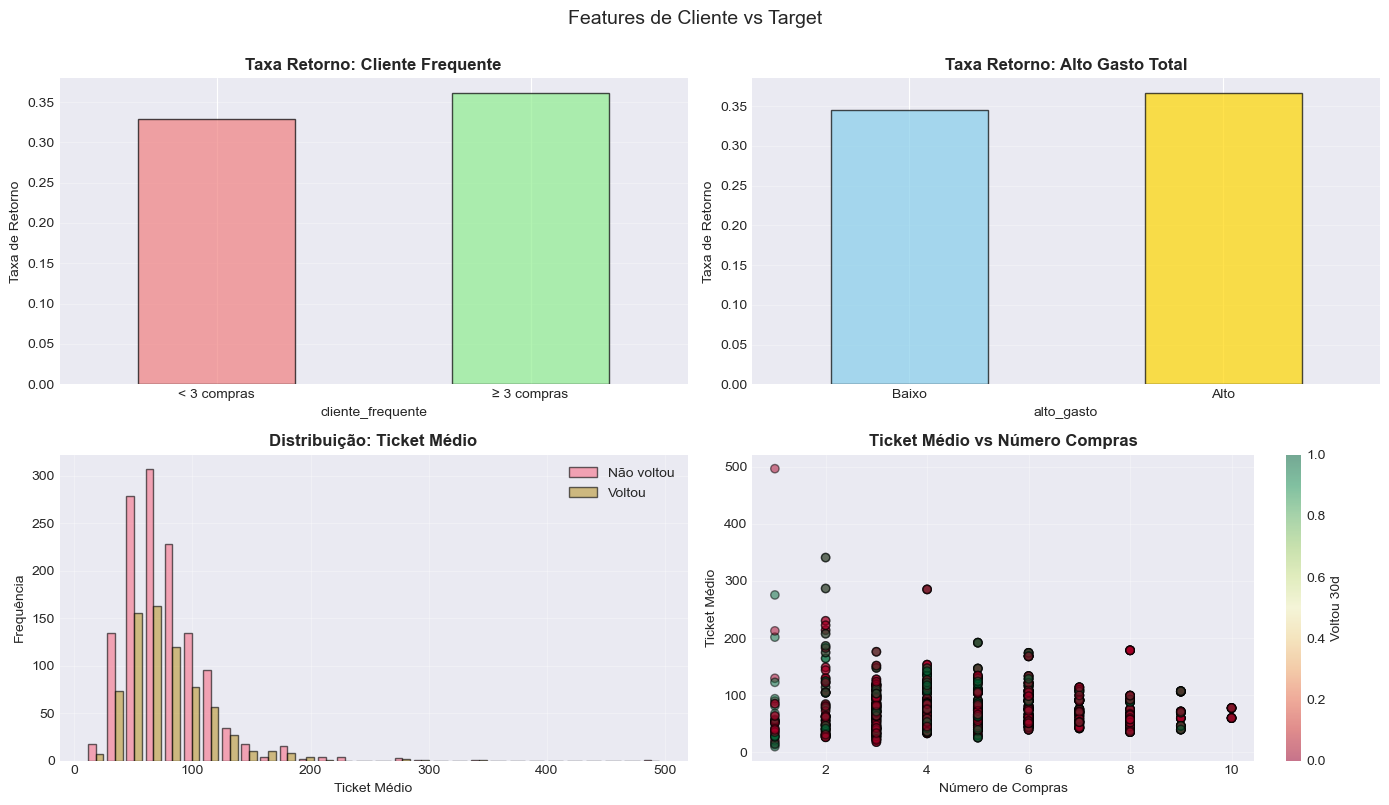


📊 Insights Agregação:
Cliente frequente: 0.361 vs 0.329
Alto gasto:        0.366 vs 0.344


In [8]:
# Visualizar features de cliente
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Features de Cliente vs Target', fontsize=14, y=1.00)

# Cliente frequente
df.groupby('cliente_frequente')['voltou_30d'].mean().plot(kind='bar', ax=axes[0, 0],
                                                            color=['lightcoral', 'lightgreen'],
                                                            alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Taxa Retorno: Cliente Frequente', fontweight='bold')
axes[0, 0].set_xticklabels(['< 3 compras', '≥ 3 compras'], rotation=0)
axes[0, 0].set_ylabel('Taxa de Retorno')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Alto gasto
df.groupby('alto_gasto')['voltou_30d'].mean().plot(kind='bar', ax=axes[0, 1],
                                                     color=['skyblue', 'gold'],
                                                     alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Taxa Retorno: Alto Gasto Total', fontweight='bold')
axes[0, 1].set_xticklabels(['Baixo', 'Alto'], rotation=0)
axes[0, 1].set_ylabel('Taxa de Retorno')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Distribuição ticket médio
axes[1, 0].hist([df[df['voltou_30d']==0]['ticket_medio'], 
                 df[df['voltou_30d']==1]['ticket_medio']], 
                bins=30, alpha=0.6, label=['Não voltou', 'Voltou'], edgecolor='black')
axes[1, 0].set_title('Distribuição: Ticket Médio', fontweight='bold')
axes[1, 0].set_xlabel('Ticket Médio')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: ticket médio vs num compras
scatter = axes[1, 1].scatter(df['num_compras'], df['ticket_medio'], 
                             c=df['voltou_30d'], cmap='RdYlGn', alpha=0.5, edgecolor='black')
axes[1, 1].set_title('Ticket Médio vs Número Compras', fontweight='bold')
axes[1, 1].set_xlabel('Número de Compras')
axes[1, 1].set_ylabel('Ticket Médio')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Voltou 30d')

plt.tight_layout()
plt.show()

print("\n📊 Insights Agregação:")
print(f"Cliente frequente: {df[df['cliente_frequente']==1]['voltou_30d'].mean():.3f} vs {df[df['cliente_frequente']==0]['voltou_30d'].mean():.3f}")
print(f"Alto gasto:        {df[df['alto_gasto']==1]['voltou_30d'].mean():.3f} vs {df[df['alto_gasto']==0]['voltou_30d'].mean():.3f}")

## 🎯 4. Feature Selection

Selecionar as features mais importantes.

In [9]:
# Preparar dados para feature selection
# Selecionar apenas features numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('voltou_30d')  # Remover target
numeric_cols.remove('customer_id')  # Remover ID

# Remover features redundantes ou temporárias
cols_to_remove = ['ano', 'dia', 'semana_ano', 'dia_ano']  # Redundantes
numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]

X = df[numeric_cols].fillna(0)
y = df['voltou_30d']

print(f"✅ Dataset preparado: {X.shape[1]} features")
print(f"\n📋 Features disponíveis:")
print(numeric_cols[:10], '...')

✅ Dataset preparado: 33 features

📋 Features disponíveis:
['valor_compra', 'desconto_pct', 'num_itens', 'tempo_site_min', 'mes', 'dia_semana', 'trimestre', 'fim_semana', 'inicio_mes', 'fim_mes'] ...


### 4.1 Feature Importance com Random Forest

✅ Feature Importance calculado!

🏆 Top 15 Features Mais Importantes:

          feature  importance
   valor_por_item    0.059786
razao_valor_tempo    0.055058
   log_tempo_site    0.054449
 tempo_medio_site    0.053261
      valor_final    0.053066
     valor_compra    0.052233
   tempo_site_min    0.051569
     ticket_medio    0.051217
        log_valor    0.049456
 variacao_compras    0.048988
        std_valor    0.048656
      valor_total    0.048505
   valor_desconto    0.044744
   desconto_medio    0.044115
      total_itens    0.043866


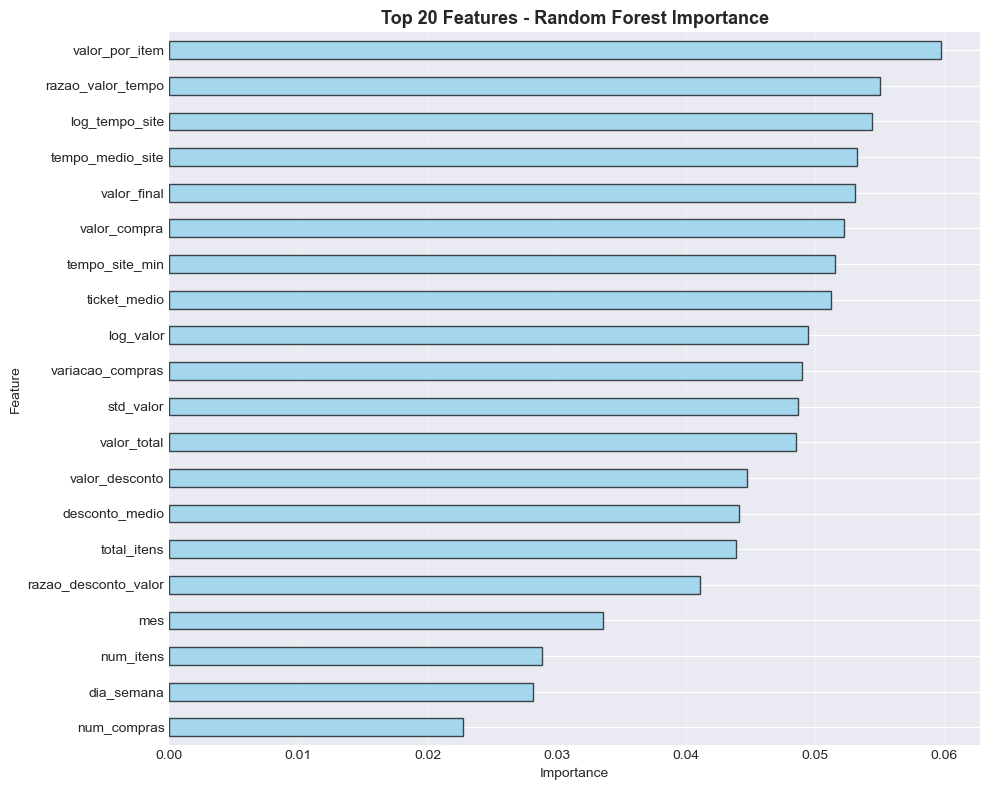

In [10]:
# Treinar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("✅ Feature Importance calculado!\n")
print("🏆 Top 15 Features Mais Importantes:\n")
print(importance_df.head(15).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
importance_df.head(20).plot(kind='barh', x='feature', y='importance', ax=ax,
                             color='skyblue', alpha=0.7, edgecolor='black', legend=False)
ax.set_title('Top 20 Features - Random Forest Importance', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 4.2 SelectKBest (ANOVA F-test)

✅ SelectKBest executado!

🏆 Top 15 Features Selecionadas:

        feature     score
 valor_desconto 15.017474
 log_tempo_site  6.893297
      log_valor  5.467932
   valor_compra  4.744411
     alto_valor  4.024022
 tempo_site_min  3.474397
tempo_site_alto  3.309006
    valor_final  3.093778
    valor_total  1.661095
 valor_por_item  1.477813
   ticket_medio  1.205812
 desconto_medio  0.987800
     alto_gasto  0.965913
            mes  0.819917
    num_compras  0.793739


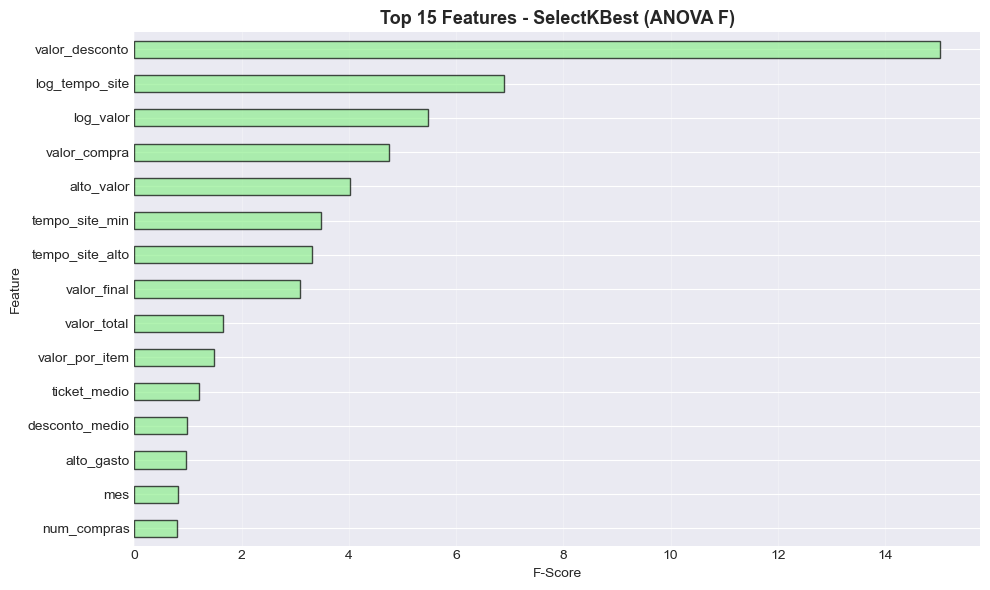

In [11]:
# SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X, y)

# Features selecionadas
selected_features = X.columns[selector.get_support()].tolist()
scores = selector.scores_[selector.get_support()]

kbest_df = pd.DataFrame({
    'feature': selected_features,
    'score': scores
}).sort_values('score', ascending=False)

print("✅ SelectKBest executado!\n")
print("🏆 Top 15 Features Selecionadas:\n")
print(kbest_df.to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))
kbest_df.plot(kind='barh', x='feature', y='score', ax=ax,
              color='lightgreen', alpha=0.7, edgecolor='black', legend=False)
ax.set_title('Top 15 Features - SelectKBest (ANOVA F)', fontsize=13, fontweight='bold')
ax.set_xlabel('F-Score')
ax.set_ylabel('Feature')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### 4.3 Comparar Seleções

In [12]:
# Top 15 de cada método
top_rf = set(importance_df.head(15)['feature'])
top_kbest = set(selected_features)

# Interseção
common_features = top_rf.intersection(top_kbest)
only_rf = top_rf - top_kbest
only_kbest = top_kbest - top_rf

print("📊 Comparação dos Métodos:\n")
print(f"Features comuns (ambos selecionaram):  {len(common_features)}")
print(f"Apenas Random Forest:                  {len(only_rf)}")
print(f"Apenas SelectKBest:                    {len(only_kbest)}")

print(f"\n🎯 Features Comuns ({len(common_features)}):")
print(list(common_features))

print(f"\n🌲 Apenas RF ({len(only_rf)}):")
print(list(only_rf))

print(f"\n📈 Apenas KBest ({len(only_kbest)}):")
print(list(only_kbest))

📊 Comparação dos Métodos:

Features comuns (ambos selecionaram):  10
Apenas Random Forest:                  5
Apenas SelectKBest:                    5

🎯 Features Comuns (10):
['desconto_medio', 'valor_total', 'valor_compra', 'log_valor', 'log_tempo_site', 'ticket_medio', 'valor_por_item', 'valor_final', 'tempo_site_min', 'valor_desconto']

🌲 Apenas RF (5):
['razao_valor_tempo', 'tempo_medio_site', 'total_itens', 'std_valor', 'variacao_compras']

📈 Apenas KBest (5):
['num_compras', 'tempo_site_alto', 'alto_gasto', 'alto_valor', 'mes']


## 📈 5. Impacto das Features no Modelo

Comparar performance com diferentes conjuntos de features.

In [13]:
# Split dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testar diferentes cenários
scenarios = {
    'Todas Features': X.columns.tolist(),
    'Top 15 RF': importance_df.head(15)['feature'].tolist(),
    'Top 10 RF': importance_df.head(10)['feature'].tolist(),
    'Top 15 KBest': selected_features,
    'Features Comuns': list(common_features)
}

results = {}

print("🔍 Testando diferentes conjuntos de features...\n")
print("="*70)

for name, features in scenarios.items():
    X_tr = X_train[features]
    X_te = X_test[features]
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    scores = cross_val_score(rf, X_tr, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    results[name] = {
        'n_features': len(features),
        'accuracy': scores.mean(),
        'std': scores.std()
    }
    
    print(f"{name:20s} | {len(features):2d} features | Acc: {scores.mean():.4f} (+/- {scores.std():.4f})")

print("="*70)

🔍 Testando diferentes conjuntos de features...

Todas Features       | 33 features | Acc: 0.6269 (+/- 0.0116)
Todas Features       | 33 features | Acc: 0.6269 (+/- 0.0116)
Top 15 RF            | 15 features | Acc: 0.6088 (+/- 0.0070)
Top 15 RF            | 15 features | Acc: 0.6088 (+/- 0.0070)
Top 10 RF            | 10 features | Acc: 0.6038 (+/- 0.0187)
Top 10 RF            | 10 features | Acc: 0.6038 (+/- 0.0187)
Top 15 KBest         | 15 features | Acc: 0.6269 (+/- 0.0171)
Top 15 KBest         | 15 features | Acc: 0.6269 (+/- 0.0171)
Features Comuns      | 10 features | Acc: 0.6275 (+/- 0.0193)
Features Comuns      | 10 features | Acc: 0.6275 (+/- 0.0193)


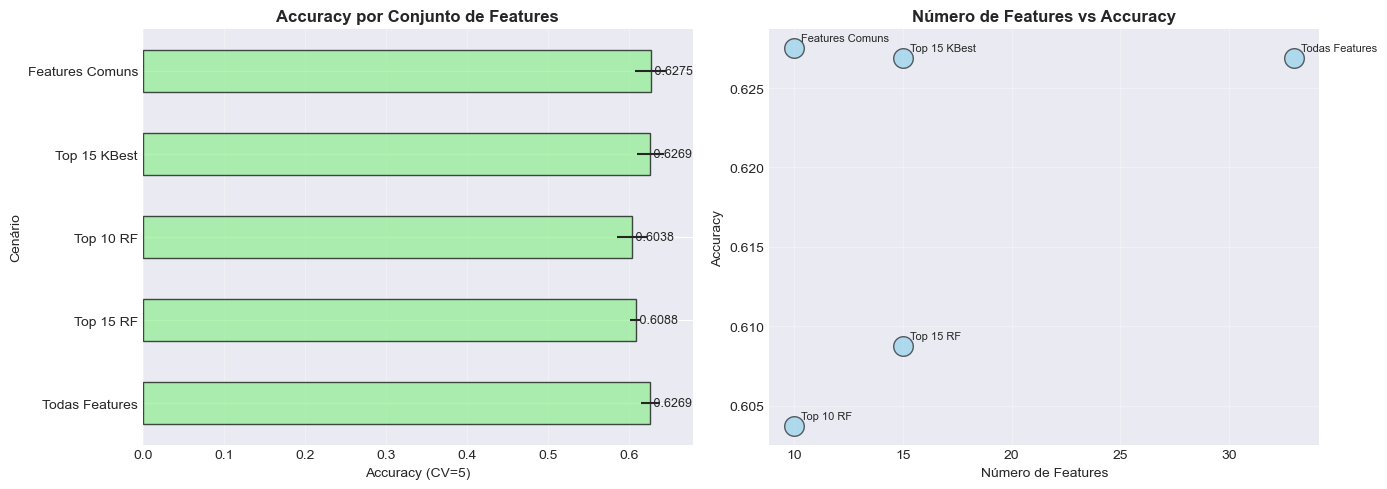


🏆 Melhor Resultado: Features Comuns
   Accuracy: 0.6275
   Features: 10

📊 vs Baseline (Todas Features):
   Melhoria: +0.0006
   Redução features: 33 → 10


In [14]:
# Visualizar resultados
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
results_df['accuracy'].plot(kind='barh', ax=axes[0], color='lightgreen', 
                             alpha=0.7, edgecolor='black', xerr=results_df['std'])
axes[0].set_title('Accuracy por Conjunto de Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Accuracy (CV=5)')
axes[0].set_ylabel('Cenário')
axes[0].grid(True, alpha=0.3, axis='x')

for idx, (name, acc) in enumerate(zip(results_df.index, results_df['accuracy'])):
    axes[0].text(acc, idx, f' {acc:.4f}', va='center', fontsize=9)

# Número de features vs Accuracy
axes[1].scatter(results_df['n_features'], results_df['accuracy'], 
                s=200, alpha=0.6, color='skyblue', edgecolor='black')
axes[1].set_title('Número de Features vs Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Número de Features')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)

for idx, name in enumerate(results_df.index):
    axes[1].annotate(name, 
                     (results_df.loc[name, 'n_features'], results_df.loc[name, 'accuracy']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Análise
best = results_df['accuracy'].idxmax()
print(f"\n🏆 Melhor Resultado: {best}")
print(f"   Accuracy: {results_df.loc[best, 'accuracy']:.4f}")
print(f"   Features: {int(results_df.loc[best, 'n_features'])}")

baseline = results_df.loc['Todas Features', 'accuracy']
improvement = results_df.loc[best, 'accuracy'] - baseline

print(f"\n📊 vs Baseline (Todas Features):")
print(f"   Melhoria: {improvement:+.4f}")
print(f"   Redução features: {X.shape[1]} → {int(results_df.loc[best, 'n_features'])}")

## ✅ Resumo Final

### 🎯 O que criamos?

1. **Features de Tempo (13)**
   - Componentes: mes, dia_semana, trimestre
   - Derivadas: fim_semana, black_friday, natal

2. **Features Matemáticas (11)**
   - Cálculos: valor_final, valor_por_item
   - Flags: alto_valor, desconto_bool
   - Transformações: log_valor, log_tempo_site

3. **Features de Agregação (9)**
   - Por cliente: ticket_medio, num_compras
   - Derivadas: cliente_frequente, alto_gasto

**Total: ~33 features criadas!**

### 📊 Aprendizados

✅ Feature Engineering pode melhorar significativamente o modelo  
✅ Não precisa de TODAS as features - selecione as melhores  
✅ Features de tempo são muito poderosas  
✅ Agregações por cliente/grupo adicionam contexto  
✅ Valide sempre com cross-validation

### 🎓 Próximos Passos

1. ✅ Aplicar em projeto real (Dia 3)
2. ✅ Documentar features criadas
3. ✅ Monitorar performance em produção

---

**🎉 Parabéns! Você dominou Feature Engineering!** 💪

**Pronto para o Dia 3: Projeto Prático Completo!** 🚀